# Reddit (small) corpus

This notebook creates a network of a small Reddit Corpus using the corpus file [downloaded through Cornell's ConvoKit library](https://convokit.cornell.edu/documentation/reddit-small.html#). This is a STAT 6990 data project.
- Author: Ashley Fehr
- Email: afehr@uvm.edu

In [67]:
import copy
import json
import os

from convokit import Corpus, download
import network_cards
import networkx as nx
import numpy as np
# from webweb import Web  # optional

import convo_structure_parsing as csp

In [2]:
# Download corpus: Only need to download the corpus one time

# corpus = Corpus(download('reddit-corpus-small'))

# find directory of corpus, likely in "User/.convokit/"
home_dir = os.path.expanduser('~')
file_path = home_dir + '/.convokit/downloads/reddit-corpus-small'
corpus = Corpus(filename=file_path)


## Explore structure of data

Some helpful convokit methods are shown in this section.

In [3]:
corpus.print_summary_stats()

Number of Speakers: 119889
Number of Utterances: 297132
Number of Conversations: 8286


In [4]:
random_conv = corpus.random_conversation()
random_conv.print_conversation_structure()

Aretardnamedtrevor2
    RandomDalish
        probably-not-a-fox
            RandomDalish
                wtfthecanuck
                    RandomDalish
            redditor_bob
                probably-not-a-fox
        P__Squared
        AmyJK7110
            RandomDalish
                AmyJK7110
                    RandomDalish


In [5]:
random_conv.get_chronological_utterance_list()[0].meta['permalink']

'/r/AskMen/comments/9ejv6x/what_is_legal_that_makes_you_ask_yourself_how_is/'

In [6]:
# 2 different conversations sharing at least 1 user who commented in both
# These were used to test the network curation.

conv = corpus.get_conversation('9fio59')
conv2 = corpus.get_conversation('9gthts')

In [7]:
conv.print_conversation_structure()

anobuzz
    monkeymamo
        GuiltyGear
            nathan8999
        dinosuma
        Alib902
        DonLaFontainesGhost
            im_a_dr_not_
                nathan8999
                    draekia
                        T-51bender
    laughingwarlock
        miketdavis
            troubleondemand
                ihsw
                    miketdavis
                three18ti
                    JOKasten
                        BenCelotil
            newsmana
                ConstitutionCrisisUS
                mOdQuArK
                    miketdavis
                        mOdQuArK
            Yider
                Rdudek
                    miketdavis
        B0B_Spldbckwrds
            vaelroth
            ngroot
        MDKAOD
            mindbleach
                saucy_mcsaucy_pants
                    mindbleach
                        saucy_mcsaucy_pants
                            Griff-And-Or
                                saucy_mcsaucy_pants
                         

In [8]:
conv.get_chronological_utterance_list()[0].meta['permalink']

'/r/business/comments/9fio59/this_is_why_piracy_exists/'

### Important meta information
- all objects have: `object.id`, `object.print_object_stats()`
- `Conversation.meta`: `title`, `num_comments`, `domain` (website), `timestamp`, `subreddit`
    - `conv.id`, `conv.to_dict()`
- `Utterance.meta`: `score`, `top_level_comment` (id), `subreddit`, `permalink`
    - `utt.text`, `utt.conversation_id`, `utt.speaker`, `utt.reply_to` (utt.id of the comment it is in reply to), `utt.to_dict()`
- `Speaker.meta`: `num_posts`, `num_comments`
    - `speaker.id`, `speaker.to_dict()`

In [9]:
# Example of retrieving the conversation structure

convo_paths = []
for path in conv.get_root_to_leaf_paths():
    # useful for utt.id or speaker.id
    convo_paths.append([utt.speaker.id for utt in path])

convo_paths

[['anobuzz',
  'monkeymamo',
  'DonLaFontainesGhost',
  'im_a_dr_not_',
  'nathan8999',
  'draekia',
  'T-51bender'],
 ['anobuzz', 'deeperest', 'nukem996', 'nathan8999'],
 ['anobuzz', 'HobbyHobs', 'txstoploss'],
 ['anobuzz', 'laughingwarlock', '-Cromm-', 'hobofats'],
 ['anobuzz', 'patssle', 'DonLaFontainesGhost'],
 ['anobuzz', 'patssle', 'kevin_m_fischer', 'jjake101'],
 ['anobuzz', 'deeperest', 'Nicolay77', '-Cromm-', 'Nicolay77'],
 ['anobuzz', 'laughingwarlock', 'colemanthor', 'bencedubois26'],
 ['anobuzz', 'HobbyHobs', 'skydivingdutch', 'joec_95123'],
 ['anobuzz', 'HobbyHobs', 'skydivingdutch', 'HobbyHobs', 'Rodec'],
 ['anobuzz', 'HobbyHobs', 'saffir', 'mattkerle'],
 ['anobuzz', 'deeperest', 'squealteam', 'timultuoustimes'],
 ['anobuzz', 'laughingwarlock', 'BumbleFuckDuck'],
 ['anobuzz', 'deeperest', 'squealteam', 'f0rtytw0'],
 ['anobuzz', 'deeperest', 'squealteam', 'Quaglar', 'JBlitzen'],
 ['anobuzz',
  'patssle',
  'kevin_m_fischer',
  'Alib902',
  'kevin_m_fischer',
  'Alib902',
 

In [10]:
# This is the user who commented in both example conversations
speaker2 = conv2.get_speaker('nathan8999')

# get all the utterances in the corpus by a particular speaker
speaker2.get_utterances_dataframe().head()

,timestamp,text,speaker,reply_to,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text,vectors
id,,,,,,,,,,,,,,,
e5xlq4a,1536878549,Not really. You can still buy it and pirate it...,nathan8999,e5ww7g5,9fio59,3,e5wouom,1539028346,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",business,False,/r/business/comments/9fio59/this_is_why_piracy...,,[]
e5xlwku,1536878704,Moral obligation to steal. Great morals.,nathan8999,e5xdtzm,9fio59,-4,e5wouom,1539028422,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",business,False,/r/business/comments/9fio59/this_is_why_piracy...,,[]
e5xlf52,1536878299,Pretty sure Apple has enough bargaining power.,nathan8999,e5x64xj,9fio59,2,e5wrmfl,1539028217,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",business,False,/r/business/comments/9fio59/this_is_why_piracy...,,[]
e5xlkxf,1536878432,Because movies are more expensive.,nathan8999,e5x1dup,9fio59,2,e5x1dup,1539028286,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",business,False,/r/business/comments/9fio59/this_is_why_piracy...,,[]
e682mbg,1537312351,Isn't what they did already illegal? That's th...,nathan8999,e66rie8,9gthts,1,e66r2s0,1539204769,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",business,False,/r/business/comments/9gthts/the_techtopus_how_...,,[]


In [11]:
# Check conversation integrity for a complete reply-to chain
# (from conversation id root to leaves)

conv.check_integrity(), conv2.check_integrity()

Checking reply-to chain of Conversation 9fio59
No issues found.

Checking reply-to chain of Conversation 9gthts
No issues found.



(True, True)

In [12]:
# Combine conversations into a list of Utterance objects
test_list_utterances = list(conv.iter_utterances()) + list(conv2.iter_utterances())

# Create a new Corpus object
new_corpus = Corpus(utterances=test_list_utterances)

new_corpus.print_summary_stats()

Number of Speakers: 100
Number of Utterances: 155
Number of Conversations: 2


## Network Creation
To potentially support different research lens and ability to facilitate a network card, I will create the network in two ways:
1) as a MultiDiGraph
2) as a weighted DiGraph

### Multi-graph

In [13]:
G = csp.parse_reddit_convo_structure(new_corpus)
G.size()

Checking reply-to chain of Conversation 9fio59
No issues found.

Checking reply-to chain of Conversation 9gthts
No issues found.



146

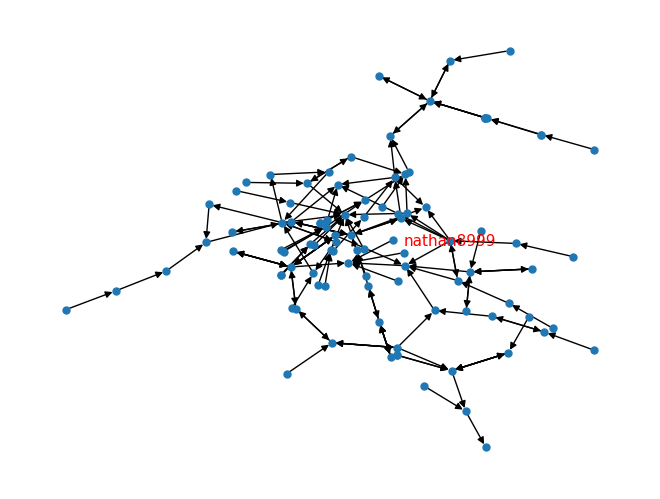

In [14]:
# Demonstrative structure from 2 conversations linked by one user replying to both

# conditionally create a dictionary of labels for nodes
users = ['nathan8999']
labels = {labels: labels for labels in G.nodes() if labels in users}

# To view directionality with the small example.
nx.draw_kamada_kawai(
    G,
    node_size=25,
    with_labels=True, labels=labels, font_color='red', font_size=11)

In [15]:
# A better illustration of the example using webweb, but
# lacking directionality (see saved svg file)

# web = Web(nx_G=G, title="Small Reddit Corpus Example")
# web.show()

In [15]:
# full MultiDiGraph network using parsing script
full_network = csp.parse_reddit_convo_structure(corpus)
full_network.size()

Checking reply-to chain of Conversation 9c716m
No issues found.

Checking reply-to chain of Conversation 9c8amk
No issues found.

Checking reply-to chain of Conversation 9ca0yk
No issues found.

Checking reply-to chain of Conversation 9cfz10
No issues found.

Checking reply-to chain of Conversation 9crqp2
No issues found.

Checking reply-to chain of Conversation 9d07z8
No issues found.

Checking reply-to chain of Conversation 9dbjxa
No issues found.

Checking reply-to chain of Conversation 9dhcnh
No issues found.

Checking reply-to chain of Conversation 9dhek8
No issues found.

Checking reply-to chain of Conversation 9dnnwe
No issues found.

Checking reply-to chain of Conversation 9drpte
No issues found.

Checking reply-to chain of Conversation 9dsufk
No issues found.

Checking reply-to chain of Conversation 9e26l0
No issues found.

Checking reply-to chain of Conversation 9e35l8
No issues found.

Checking reply-to chain of Conversation 9e4u9b
No issues found.

Checking reply-to chain o

278846

In [16]:
list(full_network.edges(data=True))[:2]

[('littlefiredragon',
  'belmont_lay',
  {'convo_id': '9c716m',
   'utt_id': 'e594xde',
   'utt_text': 'His "candid" pics look better leh',
   'utt_speaker': 'littlefiredragon',
   'utt_timestamp': 1535866404,
   'utt_score': 1}),
 ('belmont_lay',
  'littlefiredragon',
  {'convo_id': '9c716m',
   'utt_id': 'e594y7f',
   'utt_text': 'wat.. he looks like a random extra in a JAV',
   'utt_speaker': 'belmont_lay',
   'utt_timestamp': 1535866436,
   'utt_score': -3})]

In [17]:
list(full_network.nodes(data=True))[:10]

[('littlefiredragon',
  {'num_comments': 1, 'num_posts': 0, 'subreddits': ['singapore']}),
 ('belmont_lay',
  {'num_comments': 9, 'num_posts': 0, 'subreddits': ['singapore']}),
 ('rheinl', {'num_comments': 14, 'num_posts': 0, 'subreddits': ['singapore']}),
 ('sea_lecture',
  {'num_comments': 7,
   'num_posts': 0,
   'subreddits': ['singapore', 'Guildwars2', 'aww']}),
 ('deleted_speaker_0', {}),
 ('tauhuayislove',
  {'num_comments': 5, 'num_posts': 0, 'subreddits': ['singapore']}),
 ('brianne0007',
  {'num_comments': 11, 'num_posts': 0, 'subreddits': ['singapore']}),
 ('ThenPoem',
  {'num_comments': 5, 'num_posts': 0, 'subreddits': ['singapore']}),
 ('Eskipony',
  {'num_comments': 4, 'num_posts': 0, 'subreddits': ['singapore']}),
 ('RedFaceGeneral',
  {'num_comments': 3, 'num_posts': 0, 'subreddits': ['singapore', 'Games']})]

### Weighted Di-graph

In [18]:
# Netword cards are not implemented for MultiGraph types, so this card will
# provide the DiGraph type of the network.

full_di_network = csp.parse_reddit_convo_structure_digraph(corpus)

Checking reply-to chain of Conversation 9c716m
No issues found.

Checking reply-to chain of Conversation 9c8amk
No issues found.

Checking reply-to chain of Conversation 9ca0yk
No issues found.

Checking reply-to chain of Conversation 9cfz10
No issues found.

Checking reply-to chain of Conversation 9crqp2
No issues found.

Checking reply-to chain of Conversation 9d07z8
No issues found.

Checking reply-to chain of Conversation 9dbjxa
No issues found.

Checking reply-to chain of Conversation 9dhcnh
No issues found.

Checking reply-to chain of Conversation 9dhek8
No issues found.

Checking reply-to chain of Conversation 9dnnwe
No issues found.

Checking reply-to chain of Conversation 9drpte
No issues found.

Checking reply-to chain of Conversation 9dsufk
No issues found.

Checking reply-to chain of Conversation 9e26l0
No issues found.

Checking reply-to chain of Conversation 9e35l8
No issues found.

Checking reply-to chain of Conversation 9e4u9b
No issues found.

Checking reply-to chain o

In [20]:
list(full_di_network.edges(data=True))[:10]

[('littlefiredragon', 'belmont_lay', {'weight': 1}),
 ('belmont_lay', 'littlefiredragon', {'weight': 1}),
 ('belmont_lay', 'rheinl', {'weight': 6}),
 ('belmont_lay', 'sea_lecture', {'weight': 4}),
 ('belmont_lay', 'zhangsnow', {'weight': 2}),
 ('belmont_lay', 'KeythKatz', {'weight': 1}),
 ('belmont_lay', 'stereopaper', {'weight': 2}),
 ('belmont_lay', 'bobo_chacha', {'weight': 3}),
 ('rheinl', 'belmont_lay', {'weight': 4}),
 ('rheinl', 'janqn', {'weight': 1})]

## Save data to network format

In [22]:
nx.write_gml(full_network, "../reddit_small_corpus_network_multigraph.gml.gz")
nx.write_gml(full_di_network, "../reddit_small_corpus_network_digraph.gml.gz")

# Verify the save file
M = nx.read_gml("../reddit_small_corpus_network_multigraph.gml.gz")
D = nx.read_gml("../reddit_small_corpus_network_digraph.gml.gz")

M.size(), len(M.nodes()), D.size(), len(D.nodes())

(278846, 121215, 212678, 121215)

## Generate [Network Card](https://github.com/network-cards/network-cards)

In [79]:
# Make DiGraph card first so that the MultiGraph card can be updated from it
card = network_cards.NetworkCard(full_di_network)
print(card)

                   Name                         
                   Kind       Directed, weighted
              Nodes are                         
              Links are                         
       Link weights are                         
         Considerations                         
        Number of nodes                   121215
        Number of links 212678 (1087 self-loops)
--- Bidirectional links                    19.6%
      Degree (in/out)^1         1.75455 [0, 448]
             Degree^2^1          3.5091 [1, 449]
             Clustering                   0.0344
              Connected             Disconnected
 Assortativity (degree)                  -0.0477
          Node metadata                         
          Link metadata                         
       Date of creation                         
Data generating process                         
                 Ethics                         
                Funding                         
               Citat

In [51]:
card.update_overall("Name", "Small Reddit Corpus Network")
card.update_overall("Nodes are", "Users (Speaker ID)")
card.update_overall("Links are", "Replies from one user to another")
card.update_overall("Considerations", "This corpus is a sample of highly active subreddits from 2018")

card.update_metainfo({
    "Node metadata":           "Number of user posts and comments from user, subreddits participated in",
    "Link metadata":           "weight (number of replies from one user to another)",
    # this is link metadata for the multigraph
    # "Link metadata":           "Conversation ID, Utterance ID, text, Speaker ID, UNIX timestamp, and upvote score",
    "Date of creation":        "source data: 2018, network data: 2024",
    "Data generating process": "The corpus was downloaded from Cornell's ConvoKit and processed with NetworkX.",
    "Funding":                 "None",
    "Citation":                "Pushshift.io (2018) and ConvoKit (Chang et al., 2020)",
    "Ethics":                  "n/a",
    'Access':                  "https://convokit.cornell.edu/documentation/reddit-small.html#",
    })

print(card)

                   Name                                                    Small Reddit Corpus Network
                   Kind                                                             Directed, weighted
              Nodes are                                                             Users (Speaker ID)
              Links are                                               Replies from one user to another
       Link weights are                                                                               
         Considerations                  This corpus is a sample of highly active subreddits from 2018
        Number of nodes                                                                         121215
        Number of links                                                       212678 (1087 self-loops)
--- Bidirectional links                                                                          19.6%
      Degree (in/out)^1                                                  

In [71]:
# adapt from networks-cards code as multigraphs cannot be processed automatically (Bagrow & Ahn, 2022)

def count_bidirectional_links(G):
    num_directed_links = G.size()
    undirected_links = {tuple(sorted(ij)) for ij in G.edges()}
    num_bidirectional_links = num_directed_links - len(undirected_links)

    return f"{100*num_bidirectional_links/num_directed_links:.3g}%"

def summarize(values):
    return f"{np.mean(values):g} [{min(values)}, {max(values)}]"

def count_degrees(G):
    degs_un = [k for _,k in G.degree()]
    degs_in = [k for _,k in G.in_degree()] # mean in/out degree same
    # degree-in/out, degree
    return (summarize(degs_in), summarize(degs_un))

In [77]:
# custom network card for the MultiGraph network
card_mdg = copy.deepcopy(card)

card_mdg.update_overall({
    "Kind": "Directed multigraph, unweighted",
    "Links are": "Replies from one user to another (key: utterance ID)",
})

deg_in_out, degree = count_degrees(full_network)
card_mdg.update_structure({
    "Number of links": full_network.size(),
    "--- Bidirectional links": count_bidirectional_links(full_network),
    "Degree (in/out)": deg_in_out,
    "Degree": degree,
    "Clustering": "",  # cannot calculate using nx
    "Assortativity (degree)": nx.degree_assortativity_coefficient(full_network)
})

card_mdg.update_metainfo({
    "Link metadata": "Conversation ID, Utterance ID, text, Speaker ID, UNIX timestamp, and upvote score",
})

card_mdg.add_footnote_structure("Degree (in/out)", "Distributions summarized with average [min, max].")
card_mdg.add_footnote_structure("Degree", "Undirected.")
print(card_mdg)

                   Name                                                       Small Reddit Corpus Network
                   Kind                                                   Directed multigraph, unweighted
              Nodes are                                                                Users (Speaker ID)
              Links are                              Replies from one user to another (key: utterance ID)
       Link weights are                                                                                  
         Considerations                     This corpus is a sample of highly active subreddits from 2018
        Number of nodes                                                                            121215
        Number of links                                                                            278846
--- Bidirectional links                                                                             38.7%
      Degree (in/out)^1                       

In [78]:
# dump as nicely formatted JSON

with open('../network_card_multigraph.json', 'w') as f:
    json.dump(card_mdg.to_dict(), f, indent=4)

with open('../network_card_digraph.json', 'w') as f:
    json.dump(card.to_dict(), f, indent=4)